# AE332: Modelling and Analysis Lab 
## Session 3: Simulating Shells and Rockets
---
**Name:** Gaurav Gupta

**SC-Code:** SC21B026

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as sci
import scipy.interpolate as inp
import Atmosphere as atm
from matplotlib.patches import Rectangle
plt.rcParams['text.usetex'] = True

### Importing the data from excel

In [2]:
df = pd.read_excel('data-shell.xlsx')
print(df.head())
CAjoff = np.array([[0.4309, 0.4331, 0.434, 0.4084, 0.3876, 0.4582, 0.461, 0.4688, 0.4953, 0.6134],
          [0.4683, 0.4709, 0.4729, 0.4599, 0.4171, 0.4716, 0.578, 0.5858, 0.6139, 0.7416],
          [0.6796, 0.6774, 0.6797, 0.67, 0.6197, 0.6678, 0.7619, 0.7686, 0.7932, 0.9058],
          [0.7946, 0.7922, 0.7945, 0.7867, 0.7334, 0.7771, 0.8632, 0.8694, 0.8922, 0.9964],
          [0.8887, 0.886,  0.8883, 0.8826, 0.8263, 0.8663, 0.9456, 0.9513, 0.9724, 1.069],
          [0.9595, 0.9575, 0.9602, 0.9578, 0.8943, 0.9361, 1.0177, 1.023,  1.0426, 1.1323],
          [1.0027, 1.0004, 1.0031, 1.0036, 0.9379, 0.9756, 1.0529, 1.0578, 1.0761, 1.1601],
          [0.842,  0.8389, 0.8413, 0.8445, 0.8003, 0.8048, 0.8664, 0.9805, 0.9964, 1.0696],
          [0.7338, 0.7298, 0.7317, 0.7356, 0.7049, 0.6887, 0.7387, 0.832,  0.8455, 0.9076],
          [0.6602, 0.6552, 0.6567, 0.6605, 0.645,  0.611,  0.6512, 0.7246, 0.7357, 0.7873],
          [0.6441, 0.6389, 0.6402, 0.644,  0.6295, 0.5943, 0.6328, 0.7026, 0.7134, 0.7632],
          [0.62,   0.6142, 0.6153, 0.6186, 0.607,  0.5696, 0.6045, 0.6664, 0.6764, 0.7226],
          [0.5946, 0.5951, 0.5959, 0.5983, 0.5896, 0.5507, 0.5829, 0.6385, 0.6479, 0.6915],
          [0.5499, 0.5502, 0.5508, 0.5526, 0.5454, 0.5062, 0.5363, 0.5867, 0.5958, 0.638],
          [0.5347, 0.5349, 0.5352, 0.5366, 0.5311, 0.4915, 0.5199, 0.5659, 0.5747, 0.6154] 
          ])

   Mach  CNAlpha    XCPLen  MachJoff    Hjoff
0   0.2    14.57  0.842868       0.4      0.0
1   0.4    14.43  0.851050       0.6   5000.0
2   0.6    14.86  0.850584       0.8  10000.0
3   0.8    15.16  0.848138       0.9  20000.0
4   0.9    15.67  0.851823       1.0  30000.0


### Interpolation Functions

In [40]:
CNAlphaInterp = inp.interp1d(df.Mach, df.CNAlpha, kind='cubic')
CPInterp = inp.interp1d(df.Mach, df.CNAlpha, kind='cubic')
CAInterp = inp.RectBivariateSpline(df.MachJoff[:15], df.Hjoff[:10], CAjoff)

Text(0.5, 1.0, 'Variation of $C_{N\\alpha}$ with Mach Number')

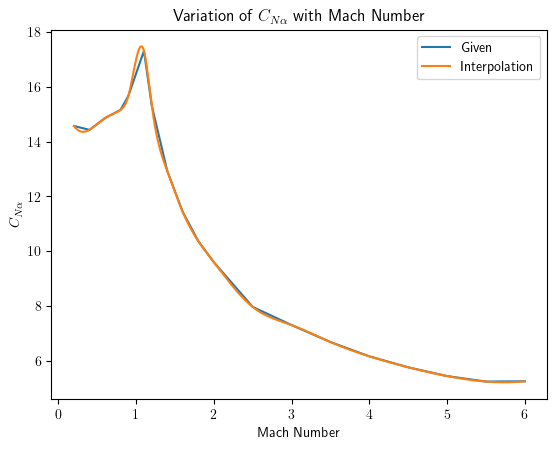

In [4]:
mach = np.linspace(0.2, 6, 10000)
plt.plot(df.Mach, df.CNAlpha, label='Given')
plt.plot(mach, CNAlphaInterp(mach),label='Interpolation')
ax = plt.gca()
ax.set_xlabel('Mach Number')
ax.set_ylabel(r'$C_{N\alpha}$')
plt.legend()
ax.set_title(r'Variation of $C_{N\alpha}$ with Mach Number')

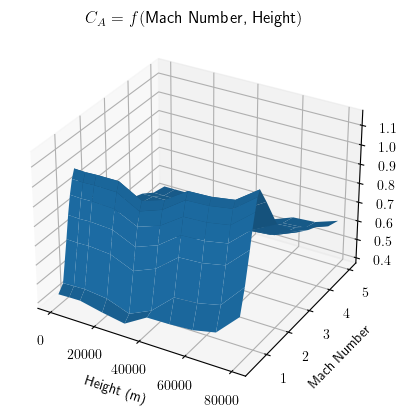

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
xx, yy = np.meshgrid(df.Hjoff[:10], df.MachJoff[:15])
surf = ax.plot_surface(xx,yy, CAjoff)
plt.xlabel('Height (m)')
plt.ylabel('Mach Number')
plt.title(r'$C_A$ = $f($Mach Number, Height$)$')
plt.show()

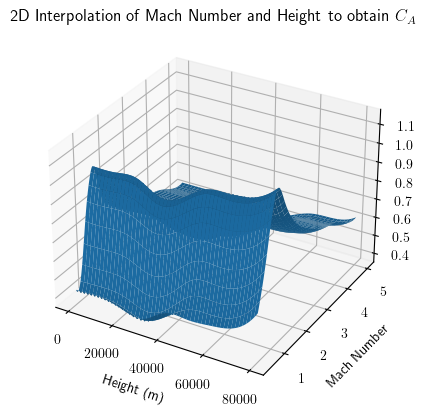

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
hh = np.linspace(0, 80000, 100000)
mm = np.linspace(0.4, 5, 1000)
xx, yy = np.meshgrid(hh,mm)
surf = ax.plot_surface(xx, yy, CAInterp(mm,hh))
plt.xlabel('Height (m)')
plt.ylabel('Mach Number')
plt.title('2D Interpolation of Mach Number and Height to obtain $C_A$')
plt.show()

### Simulation of Shell

In [8]:
l = 1.115
m = 40
I = 4.29
S = 80.12e-4
com = 0.70769
U = 867
g = 9.8
theta0 = np.radians(45)
sol0 = np.array([0, U*np.cos(theta0),0, U*np.sin(theta0), theta0, 0, 0.5*m*U*U])
def deriv(t,x):
    theta = x[4]
    alpha = theta - np.arctan2(x[3],x[1])
    v = np.hypot(x[1],x[3])
    prm = atm.atmParam(x[2],v) #Temp(h), Density(h) , Viscosity(h), Mach(h,v), logRe(h,v), Cd(h,v)
    fN = 0.5*prm[1]*v*v*S*CNAlphaInterp(prm[3])*alpha
    fA = 0.5*prm[1]*v*v*S*CAInterp(prm[3], x[2])[0][0]
    s = np.sin(theta)
    c = np.cos(theta)
    xddot = (-fN*s - fA*c)/m
    yddot = (fN*c - fA*s - m*g)/m
    thetaddot = -fN * (CPInterp(prm[3])*l - com) / I 
    if (alpha > np.radians(2)):
        raise ValueError("Alpha more than 2 Degrees")
    return [x[1], xddot, x[3], yddot, x[5], thetaddot, fA*v]

t0, tf = 0, 100
t_eval = np.linspace(0,100, 100000)

def hit_ground(t,y):
    return y[2]
hit_ground.terminal = True
hit_ground.direction = -1

In [9]:
sol = sci.solve_ivp(deriv, (t0, tf), sol0, t_eval = t_eval, dense_output=True, events=hit_ground, atol=1e-12, rtol=1e-12)

In [10]:
v = np.hypot(sol.y[1], sol.y[3])
E = m*g*sol.y[2] + 0.5*m*v*v + sol.y[6]
print("Error: ",np.max(E) - np.min(E))

Error:  1.2589255422353745


In [11]:
u = 710
theta = np.radians(45)
m = 20000
rho_s = 8000
d = np.cbrt((6*m)/(np.pi*rho_s))
s = np.pi*d*d/4
sol_sphere0 = np.array([0, u*np.cos(theta),0, u*np.sin(theta), 0.5*m*u*u])
def derive(t,u):
    v = np.hypot(u[1],u[3])
    prm = atm.atmParam(u[2],v) #Temp(h), Density(h) , Viscosity(h), Mach(h,v), logRe(h,v), Cd(h,v)
    fd = 0.5*prm[1]*v*s*prm[5]
    return [u[1], -fd*u[1]/m, u[3],  -g - (fd*u[3]/m), fd * v *v]

In [12]:
sol_sphere = sci.solve_ivp(derive, (t0, tf), sol_sphere0, t_eval = t_eval, dense_output=True, events=hit_ground)

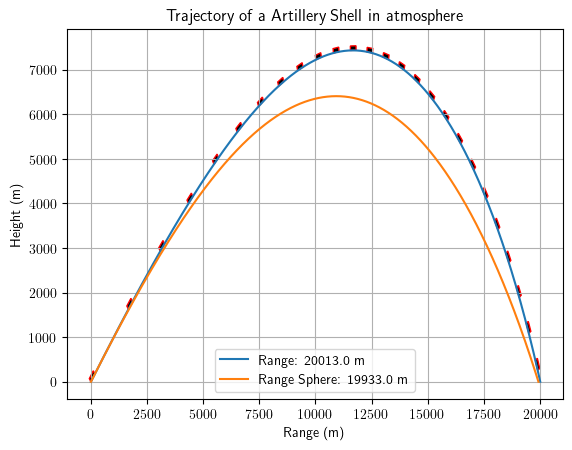

In [13]:
plt.plot(sol.y[0], sol.y[2], label='Range: {} m'.format(np.round(np.max(sol.y[0])),5))
plt.plot(sol_sphere.y[0], sol_sphere.y[2], label='Range Sphere: {} m'.format(np.round(np.max(sol_sphere.y[0])),5))
plt.xlabel('Range (m)')
plt.ylabel('Height (m)')
plt.grid()
plt.legend(loc='lower center')
plt.title('Trajectory of a Artillery Shell in atmosphere')
for x in range(0,sol.y[0].size,3000):
    plt.gca().add_patch(Rectangle((sol.y[0][x],sol.y[2][x]),250,100,
                    angle=np.degrees(sol.y[4][x]),
                    edgecolor='red',
                    facecolor='black'))

In [16]:
U_L = np.arange(200,1000,10)
l = 1.115
m = 40
I = 4.29
S = 80.12e-4
com = 0.70769
U = 867
g = 9.8
RangeL = np.empty_like(U_L)
for i in range(U_L.size):
    U = U_L[i]
    sol0 = np.array([0, U*np.cos(theta0),0, U*np.sin(theta0), theta0, 0, 0.5*m*U*U])
    sol = sci.solve_ivp(deriv, (t0, tf), sol0, t_eval = t_eval, dense_output=True, events=hit_ground)
    RangeL[i] = np.max(sol.y[0])

Text(0.5, 1.0, 'Initial Velocity v/s Range of the artilery shell')

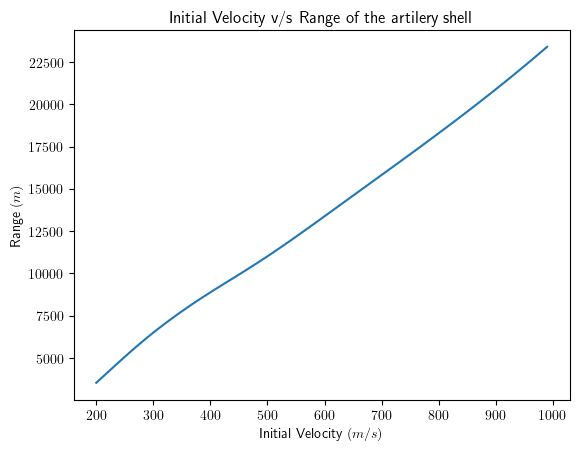

In [17]:
plt.plot(U_L, RangeL)
plt.xlabel('Initial Velocity $(m/s)$')
plt.ylabel('Range $(m)$')
plt.title('Initial Velocity v/s Range of the artilery shell')

The range of the artilery shell increases almost linearly with the initial velocity of the shell. 

## Simulation of rocket

In [51]:
dfR = pd.read_excel('data-rocket.xlsx')
print(dfR.head())
CAjon=np.array([[0.3835,	0.3857,	0.3866,	0.361,	0.3401,	0.4108,	0.4123,	0.4162,	0.428,	0.4786],
[0.4158,	0.4184,	0.4204,	0.4074,	0.3646,	0.4191,	0.5255,	0.5307,	0.549,	0.6322],
[0.6169,	0.6147,	0.617,	0.6073,	0.557,	0.6051,	0.6991,	0.7039,	0.7214,	0.801],
[0.7267,	0.7244,	0.7267,	0.7189,	0.6655,	0.7093,	0.7954,	0.7999,	0.8163,	0.8914],
[0.8158,	0.8131,	0.8154,	0.8096,	0.7534,	0.7933,	0.8726,	0.8768,	0.8922,	0.9629],
[0.8902,	0.8882,	0.8909,	0.8885,	0.825,	0.8668,	0.9484,	0.9524,	0.9668,	1.0329],
[0.9371,	0.9348,	0.9375,	0.938,	0.8722,	0.91,	0.9872,	0.9909,	1.0045,	1.067],
[0.7873,	0.7842,	0.7866,	0.7898,	0.7456,	0.7501,	0.8117,	0.9258,	0.9379,	0.9939],
[0.6864,	0.6824,	0.6843,	0.6882,	0.6575,	0.6412,	0.6913,	0.7846,	0.7953,	0.8446],
[0.6208,	0.6158,	0.6173,	0.6212,	0.6056,	0.5716,	0.6118,	0.6852,	0.6944,	0.7369],
[0.6077,	0.6024,	0.6038,	0.6075,	0.593,	0.5578,	0.5964,	0.6661,	0.6751,	0.7164],
[0.5872,	0.5814,	0.5825,	0.5858,	0.5742,	0.5367,	0.5716,	0.6336,	0.642,	0.681],
[0.5654,	0.5659,	0.5667,	0.5691,	0.5605,	0.5216,	0.5537,	0.6093,	0.6174,	0.6547],
[0.5316,	0.532,	0.5325,	0.5344,	0.5272,	0.488,	0.5181,	0.5685,	0.5763,	0.6128],
[0.5193,	0.5194,	0.5198,	0.5211,	0.5156,	0.4761,	0.5045,	0.5504,	0.5581,	0.5936]])

   Mach  C_N_Alpha      x_CP  Majoff   hAjoff  Majon     hAon     tm  \
0   0.2      14.57  0.842868     0.4      0.0    0.4      0.0  0.000   
1   0.4      14.43  0.851050     0.6   5000.0    0.6   5000.0  0.040   
2   0.6      14.86  0.850584     0.8  10000.0    0.8  10000.0  0.041   
3   0.8      15.16  0.848138     0.9  20000.0    0.9  20000.0  0.042   
4   0.9      15.67  0.851823     1.0  30000.0    1.0  30000.0  0.043   

   thrustKN  massExpelled  
0     0.000         0.000  
1     5.921         0.000  
2     6.335         0.002  
3     7.164         0.006  
4     7.933         0.011  


### Interpolation Functions

In [52]:
CNAlphaInterpR = inp.interp1d(dfR.Mach[:19], dfR.C_N_Alpha[:19], kind='cubic')
CPInterpR = inp.interp1d(dfR.Mach[:19], dfR.x_CP[:19], kind='cubic')
CA_joffInterpR = inp.RectBivariateSpline(dfR.Majoff[:15], dfR.hAjoff[:10], CAjoff)
CA_jonInterpR = inp.RectBivariateSpline(dfR.Majon[:15], dfR.hAon[:10], CAjon)
ThrustKNInterp = inp.interp1d(dfR.tm, dfR.thrustKN, kind='cubic')
massExpl_Interp = inp.interp1d(dfR.tm, dfR.massExpelled, kind='cubic')

In [106]:
l = 2.277
m0 = 88
R = 287
S = np.pi*0.207*0.207/4 #
AE = np.pi*0.125*0.125/4
com = 0.70769
U = 70
g = 9.8
mp0 = 48.771
mS = 39.229
tthrust = 11.778
theta0 = np.radians(45)
sol0 = np.array([0, U*np.cos(theta0),0, U*np.sin(theta0), theta0, 0, 0.5*m0*u*u])
def deriv(t,x):
    theta = x[4]
    alpha = theta - np.arctan2(x[3],x[1])
    v = np.hypot(x[1],x[3])
    prm = atm.atmParam(x[2],v) #Temp(h), Density(h) , Viscosity(h), Mach(h,v), logRe(h,v), Cd(h,v)
    fN = 0.5*prm[1]*v*v*S*CNAlphaInterpR(prm[3])*alpha
    if t <= tthrust:
        fA = 0.5*prm[1]*v*v*S*CA_jonInterpR(prm[3], x[2])[0][0]
        T = ThrustKNInterp(t)*1000 - prm[0]*prm[1]*R*AE
        mp = massExpl_Interp(t)
        X = (43.681 + 1.4735*mp)/(39.229 + mp)
        I = 16.318 + 39.229*(1.1135-X)**2 + (0.0979 + (1.4735 - X)**2)*mp
    else:
        fA = 0.5*prm[1]*v*v*S*CA_joffInterpR(prm[3], x[2])[0][0]
        T = 0
        mp = 0
        I = 16.318
    m = mp + mS
    s = np.sin(theta)
    c = np.cos(theta)
    xddot = (T*c -fN*s - fA*c)/m
    yddot = (fN*c + T*s - fA*s - m*g)/m
    thetaddot = -fN * (CPInterpR(prm[3])*l - com) / I 
    if (alpha > np.radians(2)):
        raise ValueError("Alpha more than 2 Degrees")
    return [x[1], xddot, x[3], yddot, x[5], thetaddot, fA*v]

t0, tf = 0, 1000
t_eval = np.linspace(0,1000, 100000)


def hit_ground(t,y):
    return y[2]
hit_ground.terminal = True
hit_ground.direction = -1

In [107]:
sol = sci.solve_ivp(deriv, (t0, tf), sol0, t_eval = t_eval, dense_output=True, events=hit_ground)

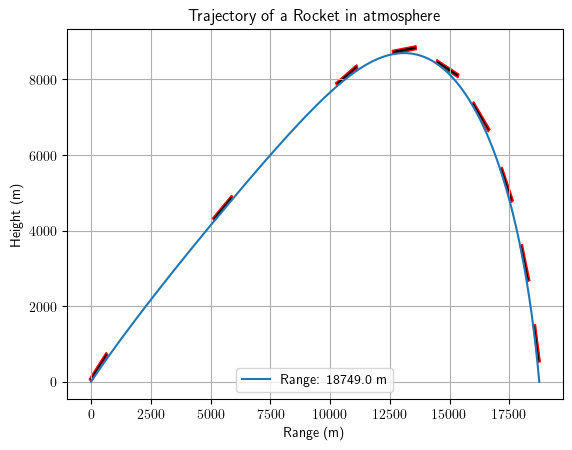

In [109]:
plt.plot(sol.y[0], sol.y[2], label='Range: {} m'.format(np.round(np.max(sol.y[0])),5))
plt.xlabel('Range (m)')
plt.ylabel('Height (m)')
plt.grid()
plt.legend(loc='lower center')
plt.title('Trajectory of a Rocket in atmosphere')
for x in range(0,sol.y[0].size,1000):
    plt.gca().add_patch(Rectangle((sol.y[0][x],sol.y[2][x]),1000,100,
                    angle=np.degrees(sol.y[4][x]),
                    edgecolor='red',
                    facecolor='black'))
    

In [113]:
angle = np.arange(0,90,1)
Range_L  = np.empty_like(angle)
Height_L = np.empty_like(angle)
for i in range(angle.size):
    print(angle[i])
    theta0 = np.radians(angle[i])
    sol0 = np.array([0, U*np.cos(theta0),0, U*np.sin(theta0), theta0, 0, 0.5*m0*u*u])
    sol = sci.solve_ivp(deriv, (t0, tf), sol0, t_eval = t_eval, dense_output=True, events=hit_ground)
    Range_L[i] = np.max(sol.y[0])
    Height_L[i] = np.max(sol.y[2])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85


ValueError: A value (0.1981142345260873) in x_new is below the interpolation range's minimum value (0.2).

In [116]:
print("Angle with Maximum Range: ", angle[np.where(Range_L==np.max(Range_L))][0])
print("Angle with Maximum Height: ", angle[np.where(Height_L==np.max(Height_L))][0])

Angle with Maximum Range:  89
Angle with Maximum Height:  87


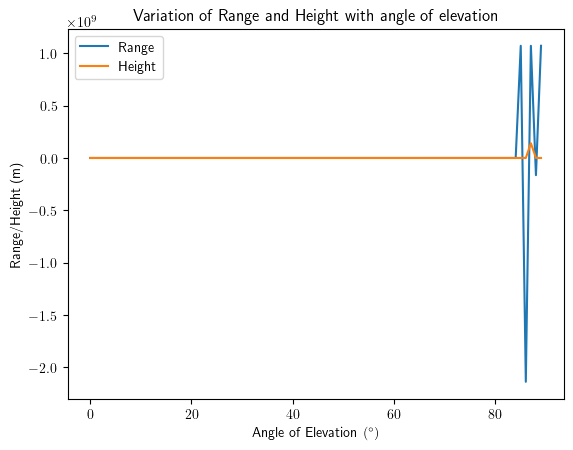

In [117]:
plt.plot(angle, Range_L, label='Range')
plt.plot(angle, Height_L, label='Height')
plt.title("Variation of Range and Height with angle of elevation")
plt.xlabel("Angle of Elevation $(^\circ)$")
plt.ylabel("Range/Height (m)")
plt.legend()